# Zooplankton biomass
<div>
<img src="https://img.pagecloud.com/dZrHVa1h6KM_DQHq7w-SP_Lk7oo=/462x0/filters:no_upscale()/scientific-illustrations-by-kristen/images/copepod-n260e.png" width="300"/>
</div>

A copepod, a type of zooplankton. Art credit: [Kristen Krumhardt](https://www.earthaliveillos.com/)

---

## Overview
Zooplankton are tiny oceanic animals, making up the next step up after phytoplankton in the food web. Here we evaluate modeled zooplankton biomass and compare to observational data.

1. General setup
2. Subsetting
4. Processing data
5. Mapping zooplankton biomass at the surface
6. Comparing mesozooplankton biomass to observations
7. Making monthly climatology maps to compare to observations
   
TO DO: See if COPEPOD map is correct, add more about how to access COPEPOD data, add more narrative text, clean up comments, add references

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Dask Cookbook](https://projectpythia.org/dask-cookbook/README.html) | Helpful | |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray.html) | Helpful | |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |

- **Time to learn**: 30 min


---

## Imports

In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
from dask.distributed import LocalCluster

## General setup (see intro notebooks for explanations)

### Connect to cluster

In [2]:
cluster = LocalCluster()
client = cluster.get_client()

/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40341 instead
  warnings.warn(


### Bring in POP grid utilities

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    # Trick cartopy into doing the right thing:
    # it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    # Periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Load the data

In [5]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/derecho/scratch/eromashkova/ocean-bgc-cookbook-data/cesm/'+case+'/ocn/proc/tseries/month_1'
coords = {'x':'TLONG','y':'TLAT'}
path

'/glade/derecho/scratch/eromashkova/ocean-bgc-cookbook-data/cesm/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1'

In [6]:
files = glob.glob(f'{path}/{case}.pop.h.*.195801-202112.nc')
ds=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True,
                       drop_variables=["transport_components", "transport_regions", 'moc_components'], decode_times=True)
ds

<xarray.Dataset> Size: 182GB
Dimensions:                         (nlat: 384, nlon: 320, time: 768, z_t: 60,
                                     z_w: 60, lat_aux_grid: 395, moc_z: 61,
                                     d2: 2, z_t_150m: 15, z_w_bot: 60,
                                     z_w_top: 60)
Coordinates:
    TLAT                            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lat_aux_grid                    (lat_aux_grid) float32 2kB -79.49 ... 90.0
  * moc_z                           (moc_z) float32 244B 0.0 1e+03 ... 5.5e+05
  * time                            (time) object 6kB 1958-02-01 00:00:00 ......
  * z_t                             (z_t) float32 240B 500.0 ... 5.375e+05
  * z_t_150m                        (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                             (z_w) float32 240B 0.0 1e+03 ... 5.25e+05
  * z_w_bot                         (z_w_bot) float32 240B 1e+03 ... 5.5e+05
  * z_w_top                         (z_w_top) float32 240B 0.0 ... 5.25e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables: (12/96)
    ANGLE                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ANGLET                          (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXT                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXU                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYT                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYU                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                              ...
    sp_Fe_lim_Cweight_avg_100m      (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_Fe_lim_surf                  (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_N_lim_Cweight_avg_100m       (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_N_lim_surf                   (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_P_lim_Cweight_avg_100m       (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_P_lim_surf                   (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
Attributes:
    title:             g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch
    history:           Wed Jun 21 08:37:09 2023: ncks -O -4 -L 1 /glade/scrat...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-06-13 at 16:35:05.0
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    NCO:               netCDF Operators version 5.1.4 (Homepage = http://nco....

## Subsetting

In [7]:
variables =['mesozooC', 'microzooC']

In [8]:
keep_vars=['z_t','z_t_150m','dz','time_bound','time','TAREA','TLAT','TLONG'] + variables
ds = ds.drop_vars([v for v in ds.variables if v not in keep_vars])

## Processing - global mean in time

Pull in the functions we defined in the nutrients notebook...

In [9]:
def year_mean(ds):
    """
    Add a docstring
    Source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.year").sum().values, np.ones((len(ds.groupby("time.year")), )))

    # Calculate the weighted average
    return (ds * weights).groupby("time.year").sum(dim="time")

In [10]:
# Take the long-term mean of our data set, processing years and months separately (improve this comment)

ds_annual = year_mean(ds).mean("year")

## Plot mesozooplankton and microzooplankton biomass at the surface

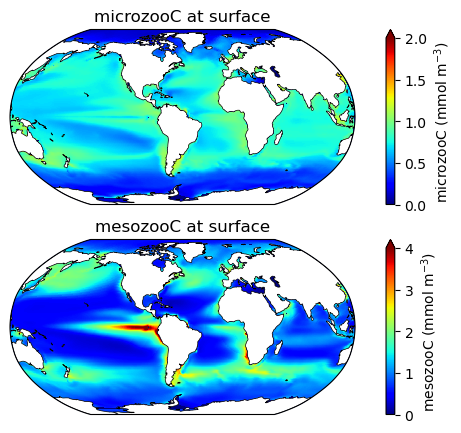

In [11]:
fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('microzooC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds_annual.microzooC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='microzooC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)


ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('mesozooC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds_annual.mesozooC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mesozooC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

## Compare mesozooplankton biomass to COPEPOD database

[Moriarty & O'Brien, 2013](https://essd.copernicus.org/articles/5/45/2013/essd-5-45-2013.pdf)

### Read in COPEPOD data

In [12]:
file = 'data/0_25x0_25/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_dataset(file, engine="zarr")

### converting grams to moles
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

In [13]:
ds_copepod

<xarray.Dataset> Size: 17MB
Dimensions:    (lat: 720, lon: 1440)
Coordinates:
  * lat        (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon        (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    copepod_C  (lat, lon) float64 8MB nan nan nan nan nan ... nan nan nan nan
    n_obs      (lat, lon) float64 8MB ...
Attributes:
    file_in:  data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass...

### Plot

<>:11: SyntaxWarning: invalid escape sequence '\i'
<>:11: SyntaxWarning: invalid escape sequence '\i'
/glade/derecho/scratch/eromashkova/tmp/ipykernel_8859/2661894306.py:11: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title('CESM ${\it Mesozooplankton}$ biomass', fontsize=12)


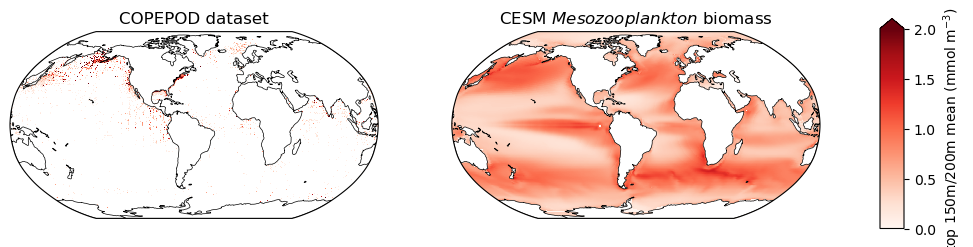

In [14]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('COPEPOD dataset', fontsize=12)
#lon, lat, field = adjust_pop_grid(lons, lats, ds_copepod.copepod_C)
pc=ax.pcolormesh(ds_copepod.lon, ds_copepod.lat, ds_copepod.copepod_C, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM ${\it Mesozooplankton}$ biomass', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, ds_annual.mesozooC.mean(dim='z_t_150m'))
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='top 150m/200m mean (mmol m$^{-3}$)');

## Making monthly climatology maps to compare to observations

### Compare to observation-based GLMM of global mesozooplankton biomass climatology 
[Heneghan et al., 2020](https://www.sciencedirect.com/science/article/abs/pii/S0304380020303355)

[Petrik et al., submitted to Global Biogeochemical Cycles](https://www.essoar.org/doi/abs/10.1002/essoar.10510705.1)

In [15]:
file = 'data/obsglmm_zmeso_vint_200m_monthly_climatology.nc'
ds_copepod_clim = xr.open_dataset(file)
ds_copepod_clim.zmeso200.attrs['units'] = 'mgC m-2'

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

### Make our CESM data into a monthly climatology

In [16]:
mon_ds = ds.copy()
mon_ds = ds.groupby('time.month').mean('time')

In [17]:
### depth integrate and convert model to mol/m2
mon_ds['mesozooC_zint'] = ((mon_ds.mesozooC) * 10.).sum(dim='z_t_150m') #in mmol/m2
mon_ds['mesozooC_zint'] = mon_ds['mesozooC_zint'] * 12.011 #convert to mgC/m2
mon_ds['mesozooC_zint'].attrs['units'] = 'mgC m-2'

### Plot

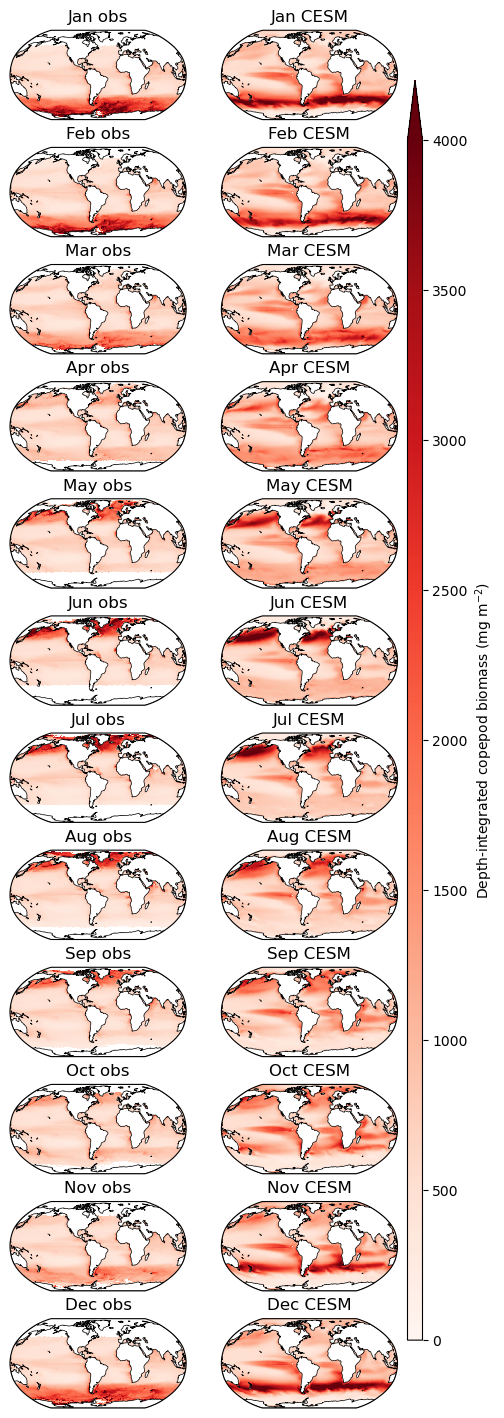

In [18]:
fig = plt.figure(figsize=(5,18))

for row in np.arange(1,13):
    
    ts=row-1
    
    plot = row*2 - 1
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' obs', fontsize=12)
    pc=ax.pcolormesh(ds_copepod_clim.Lon, ds_copepod_clim.Lat, ds_copepod_clim.zmeso200.isel(month=ts), 
                     cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
    ax.add_feature(land)
    
    plot = row*2
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' CESM', fontsize=12)
    tmp = mon_ds.mesozooC_zint.isel(month=ts)
    lon, lat, field = adjust_pop_grid(lons, lats,  tmp)
    pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
    ax.add_feature(land)

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='Depth-integrated copepod biomass (mg m$^{-2}$)');

And close the Dask cluster we spun up at the beginning.

In [19]:
cluster.close()

2024-04-02 23:27:59,077 - distributed.nanny - WARNING - Worker process still alive after 3.1999969482421875 seconds, killing


---

## Summary
You've learned how to evaluate zooplankton biomass modeled by CESM-MARBL and compare to observations.

## Resources and references
- [Moriarty & O'Brien, 2013](https://essd.copernicus.org/articles/5/45/2013/essd-5-45-2013.pdf)
- [Heneghan et al., 2020](https://www.sciencedirect.com/science/article/abs/pii/S0304380020303355)
- [Petrik et al., submitted to Global Biogeochemical Cycles](https://www.essoar.org/doi/abs/10.1002/essoar.10510705.1)